# This notebook performs exploratory data analysis over train set of disaster tweets Kaggle challenge. It uses some of the existing solutions proposed for EDA by kagglers with also my own analysis

In [28]:
import pandas as pd
import numpy as np

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
from nltk.corpus import stopwords
from collections import Counter
import string
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [12]:
train_df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


No nans in text or target, some missing values in keyword column, lots in location

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Slightly imbalanced dataset, that shoudn't influence modelling greatly

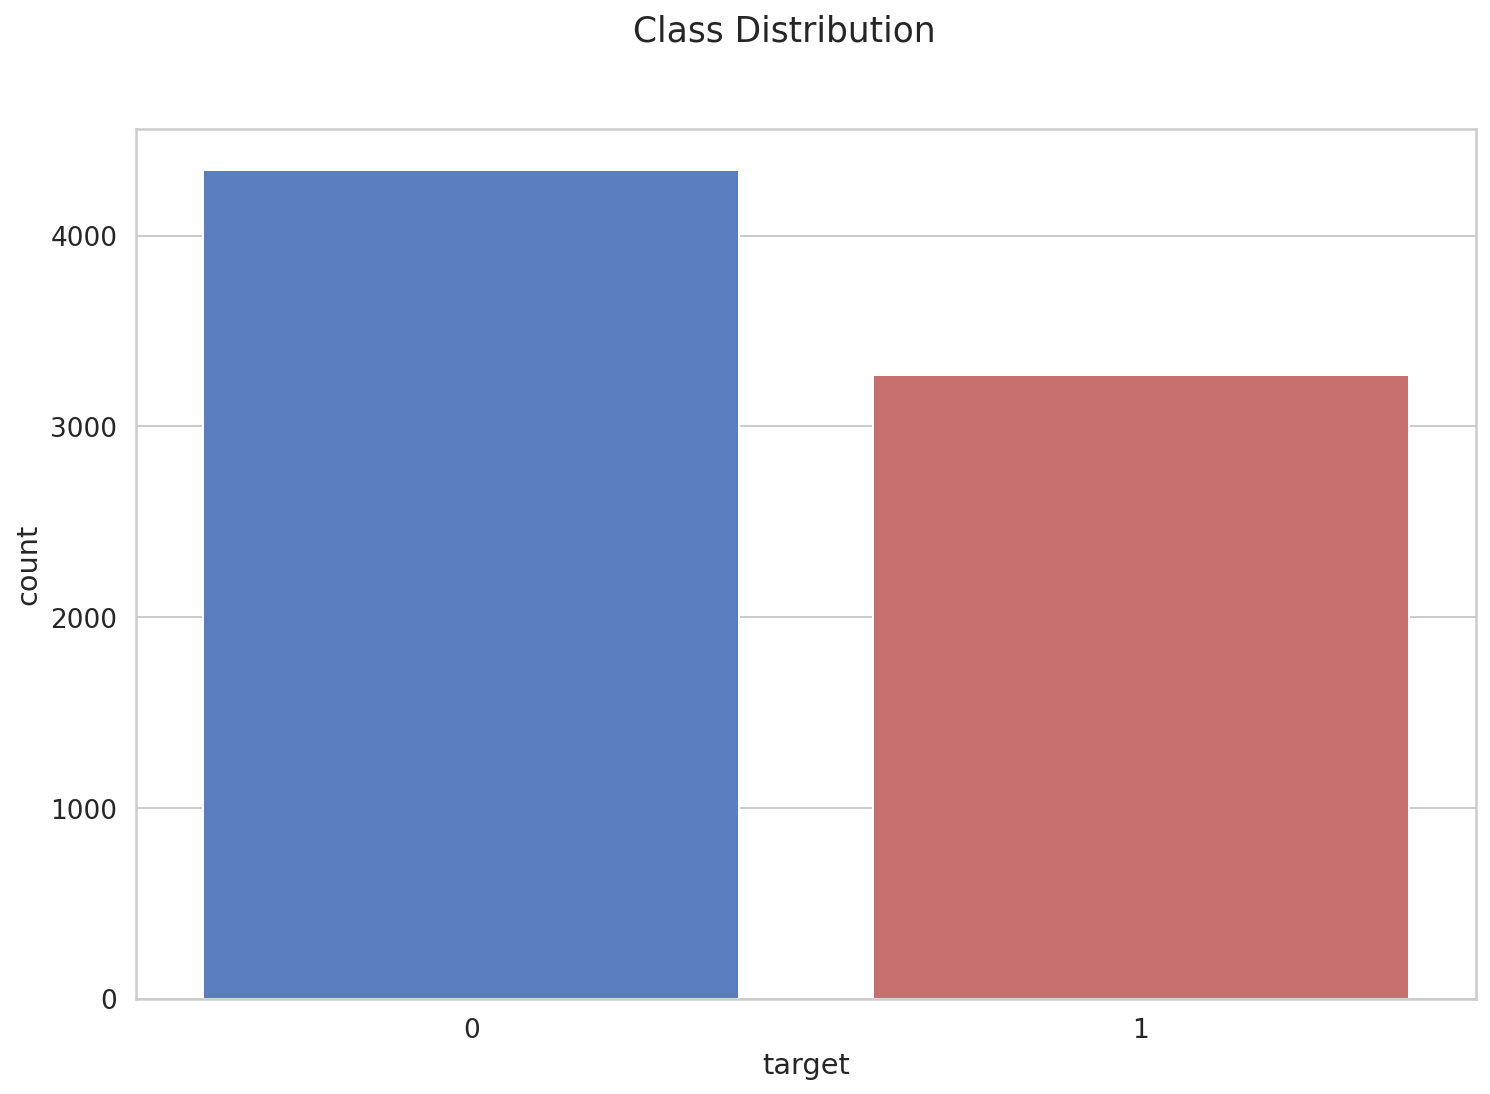

In [15]:
sns.countplot(x='target', data=train_df, palette=['b', 'r'])

plt.suptitle('Class Distribution')
plt.show()

In [9]:
train_df['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
body%20bags              41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [21]:
train_df['keyword'] = train_df['keyword'].apply(lambda x: str(x).replace('%20', ' '))
#fix keyword spacing issue for clarity

Probably non-disaster tweets contain somewhat more vague/abstract keywords while disaster ones have more specific notions

<Figure size 720x360 with 0 Axes>

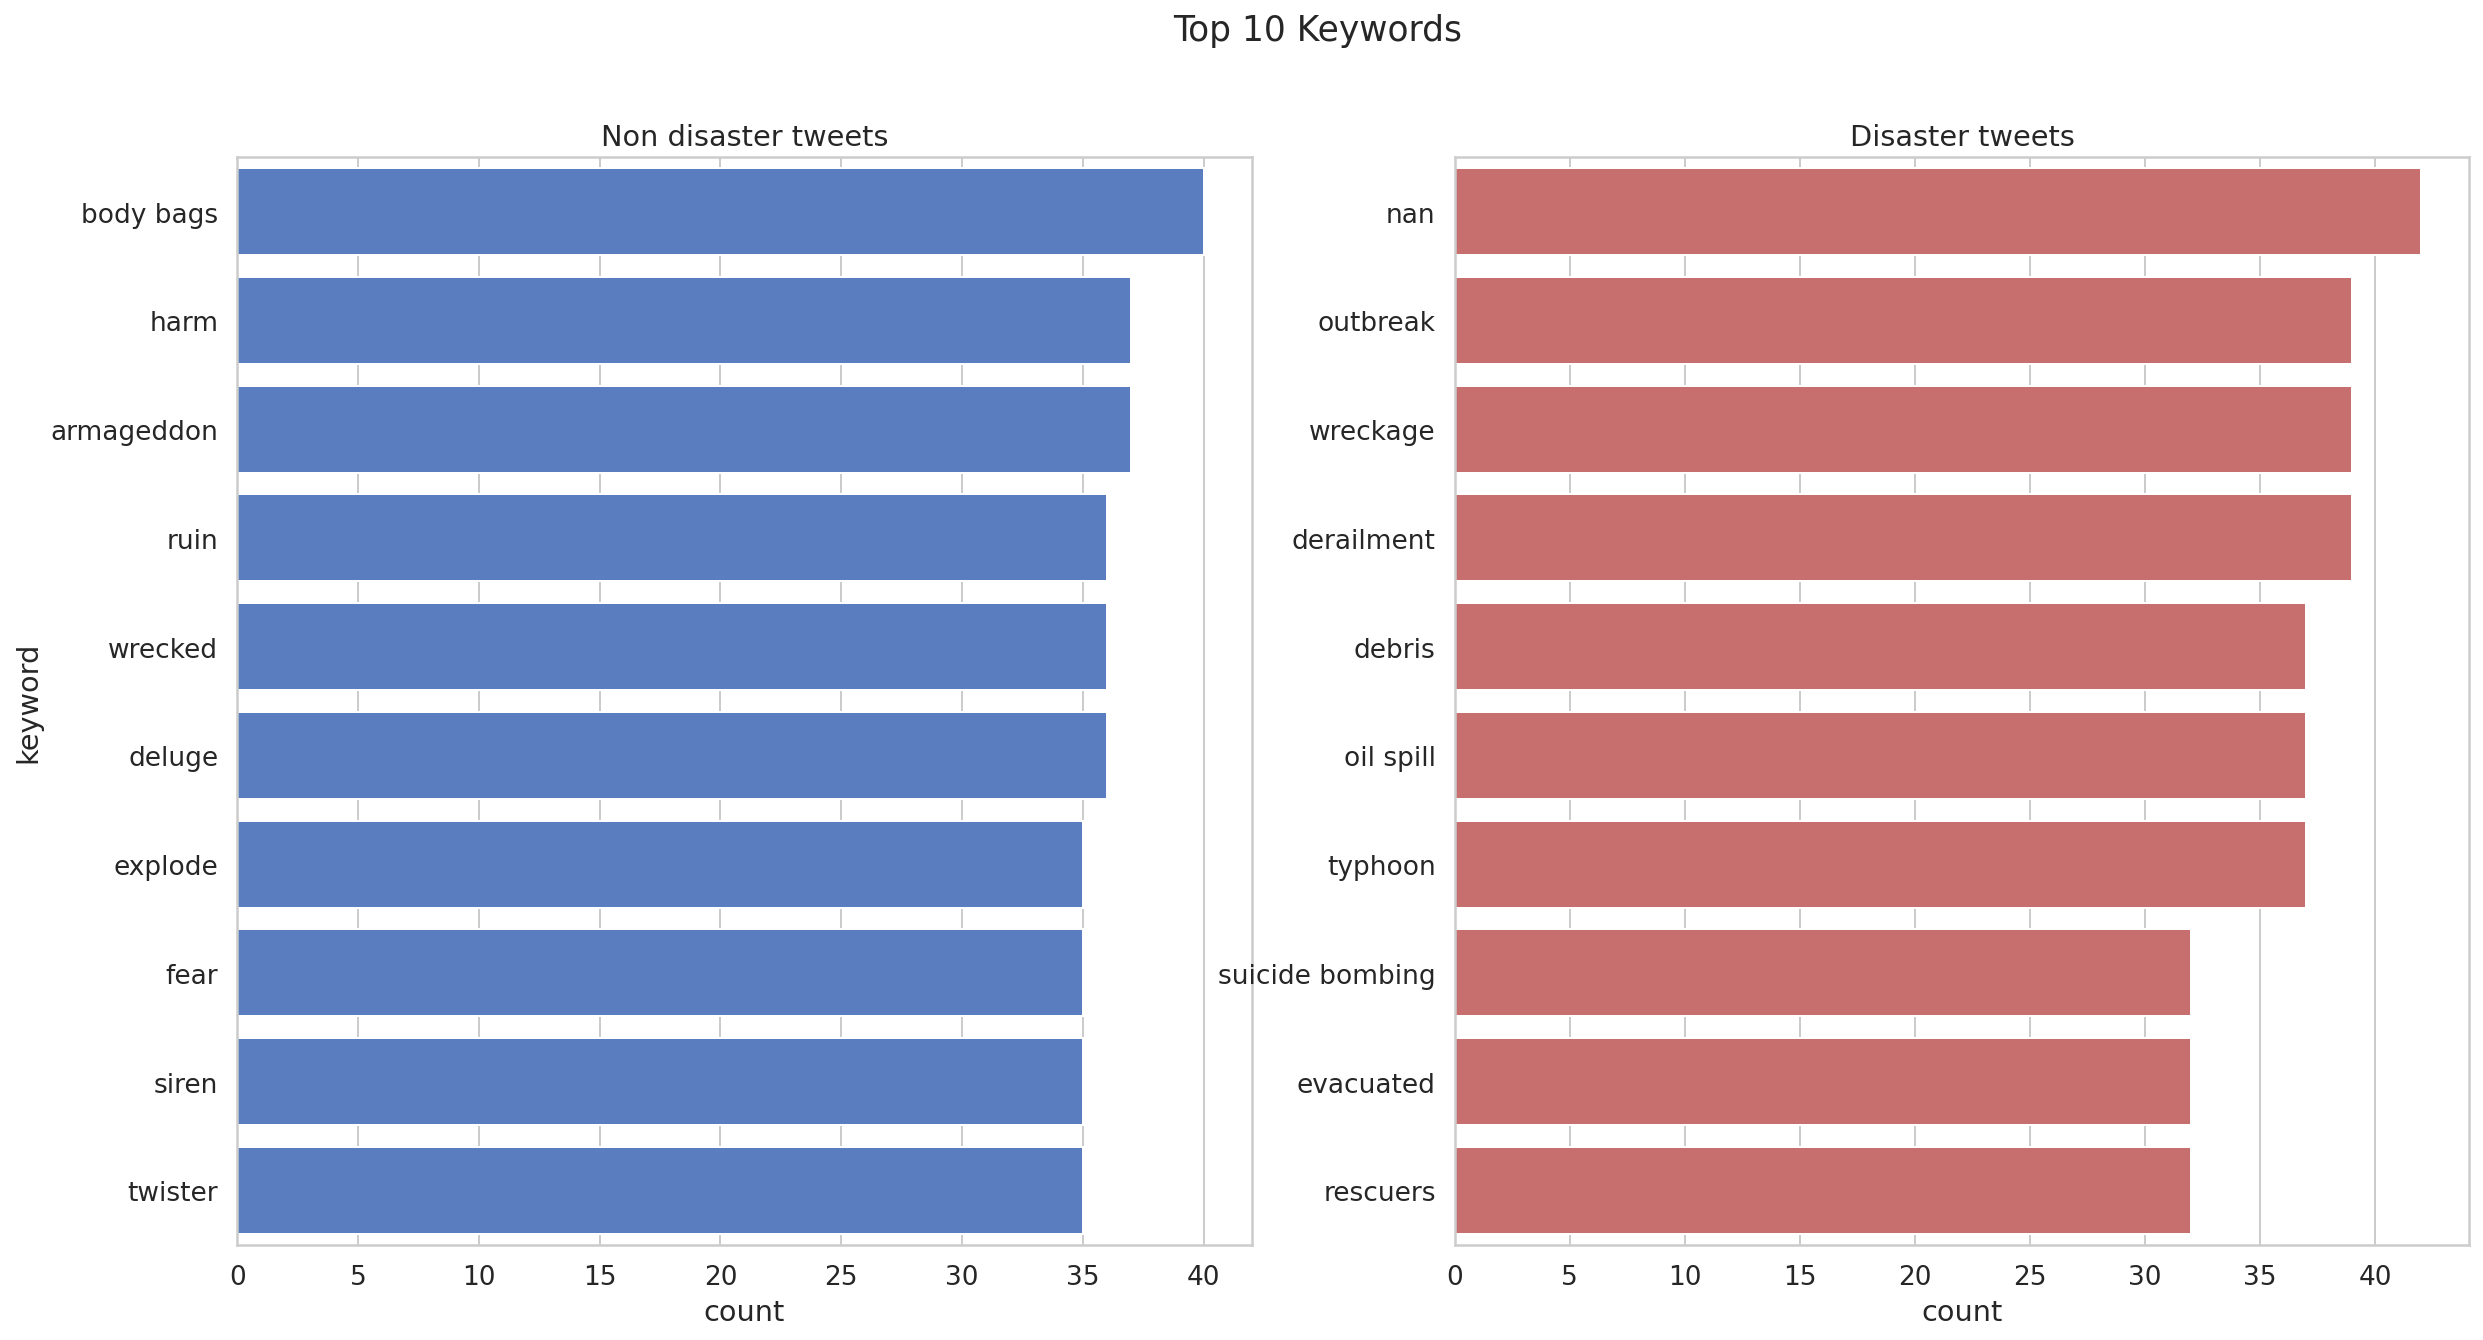

In [22]:
#top 10 keywords
disaster_count = train_df[train_df['target']==1]['keyword'].value_counts()
none_disaster_count = train_df[train_df['target']==0]['keyword'].value_counts()

disaster_count = disaster_count[:10]
none_disaster_count = none_disaster_count[:10]

plt.figure(figsize=(10, 5))

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20,10))

sns.barplot(x=none_disaster_count.values, y=none_disaster_count.index, ax=ax1, color='b')
ax1.set(xlabel='count', ylabel='keyword', title='Non disaster tweets')

sns.barplot(x=disaster_count.values, y=disaster_count.index, ax=ax2, color='r')
ax2.set(xlabel='count', title='Disaster tweets')

plt.suptitle('Top 10 Keywords')
plt.show()

Disasters tend to happen in India/Nigeria more ofter, non-disasters are in the US/UK

<Figure size 720x360 with 0 Axes>

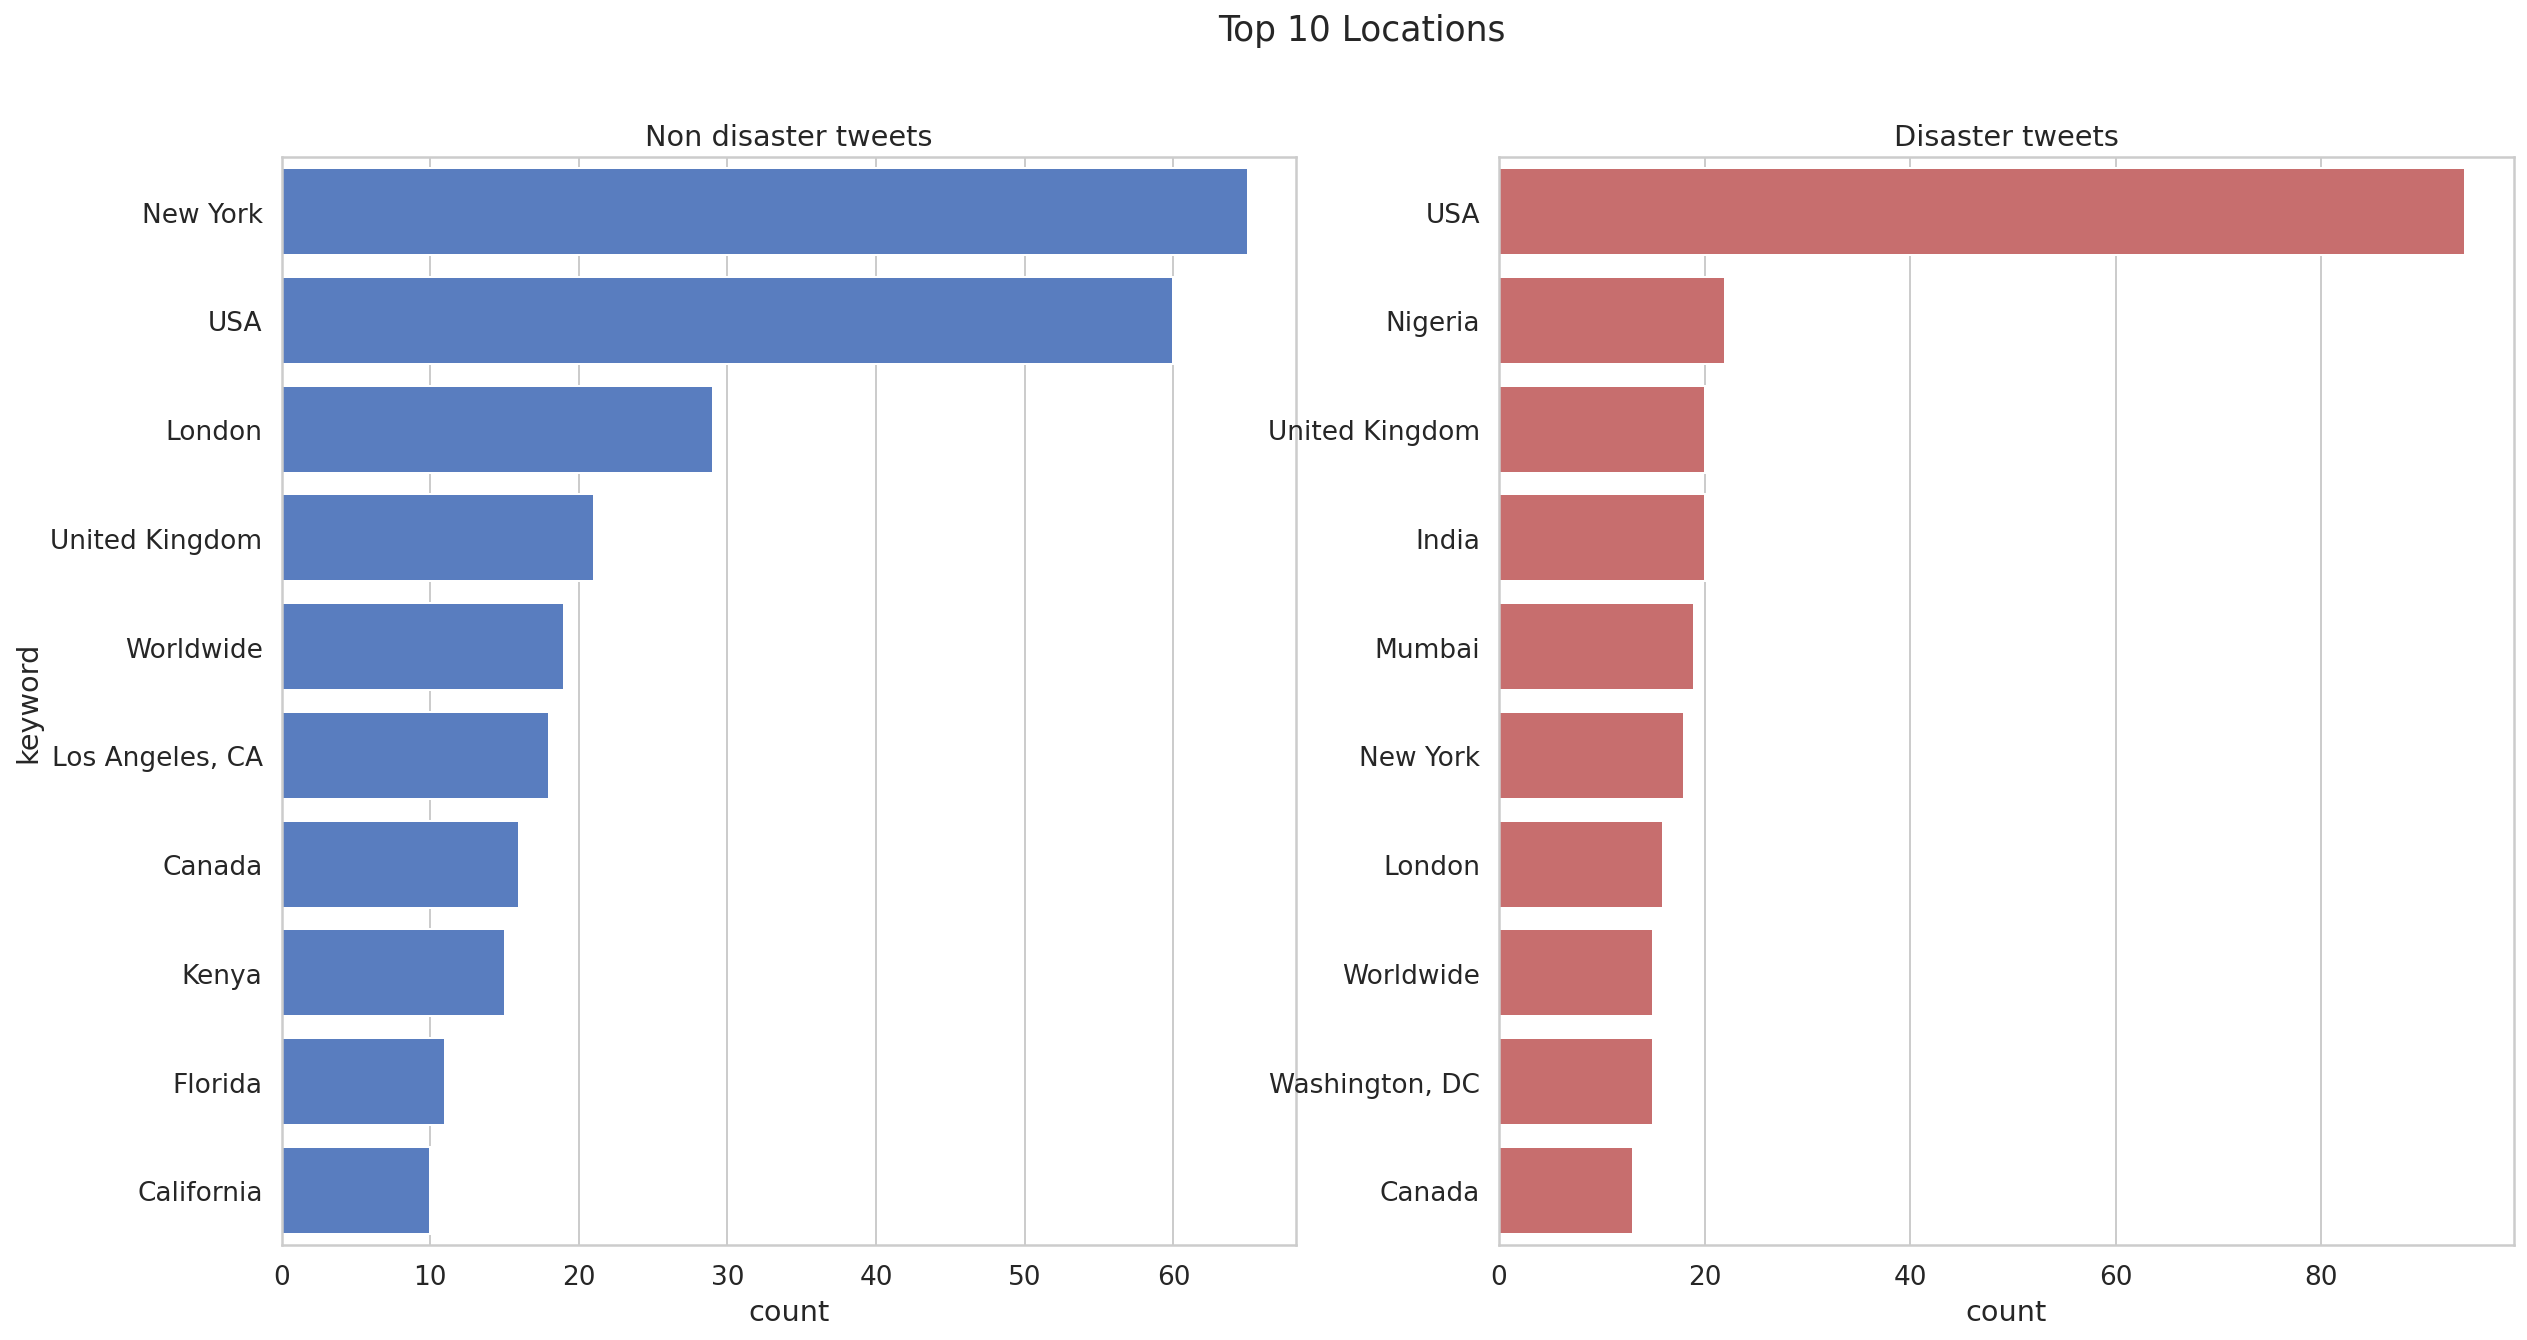

In [26]:
#top 10 locations

train_df.loc[train_df['location']=='United States', 'location'] = 'USA' #normalize USA
train_df.loc[train_df['location']=='NYC', 'location'] = 'New York' #normalize NYC
train_df.loc[train_df['location']=='UK', 'location'] = 'United Kingdom' #normalize UK
train_df.loc[train_df['location']=='Everywhere', 'location'] = 'Worldwide' #normalize Everywhere

disaster_count = train_df[train_df['target']==1]['location'].value_counts()
none_disaster_count = train_df[train_df['target']==0]['location'].value_counts()

disaster_count = disaster_count[:10]
none_disaster_count = none_disaster_count[:10]

plt.figure(figsize=(10, 5))

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20,10))

sns.barplot(x=none_disaster_count.values, y=none_disaster_count.index, ax=ax1, color='b')
ax1.set(xlabel='count', ylabel='keyword', title='Non disaster tweets')

sns.barplot(x=disaster_count.values, y=disaster_count.index, ax=ax2, color='r')
ax2.set(xlabel='count', title='Disaster tweets')

plt.suptitle('Top 10 Locations')
plt.show()

Which types of (non-)disasters happen at which parts of the world

<Figure size 720x360 with 0 Axes>

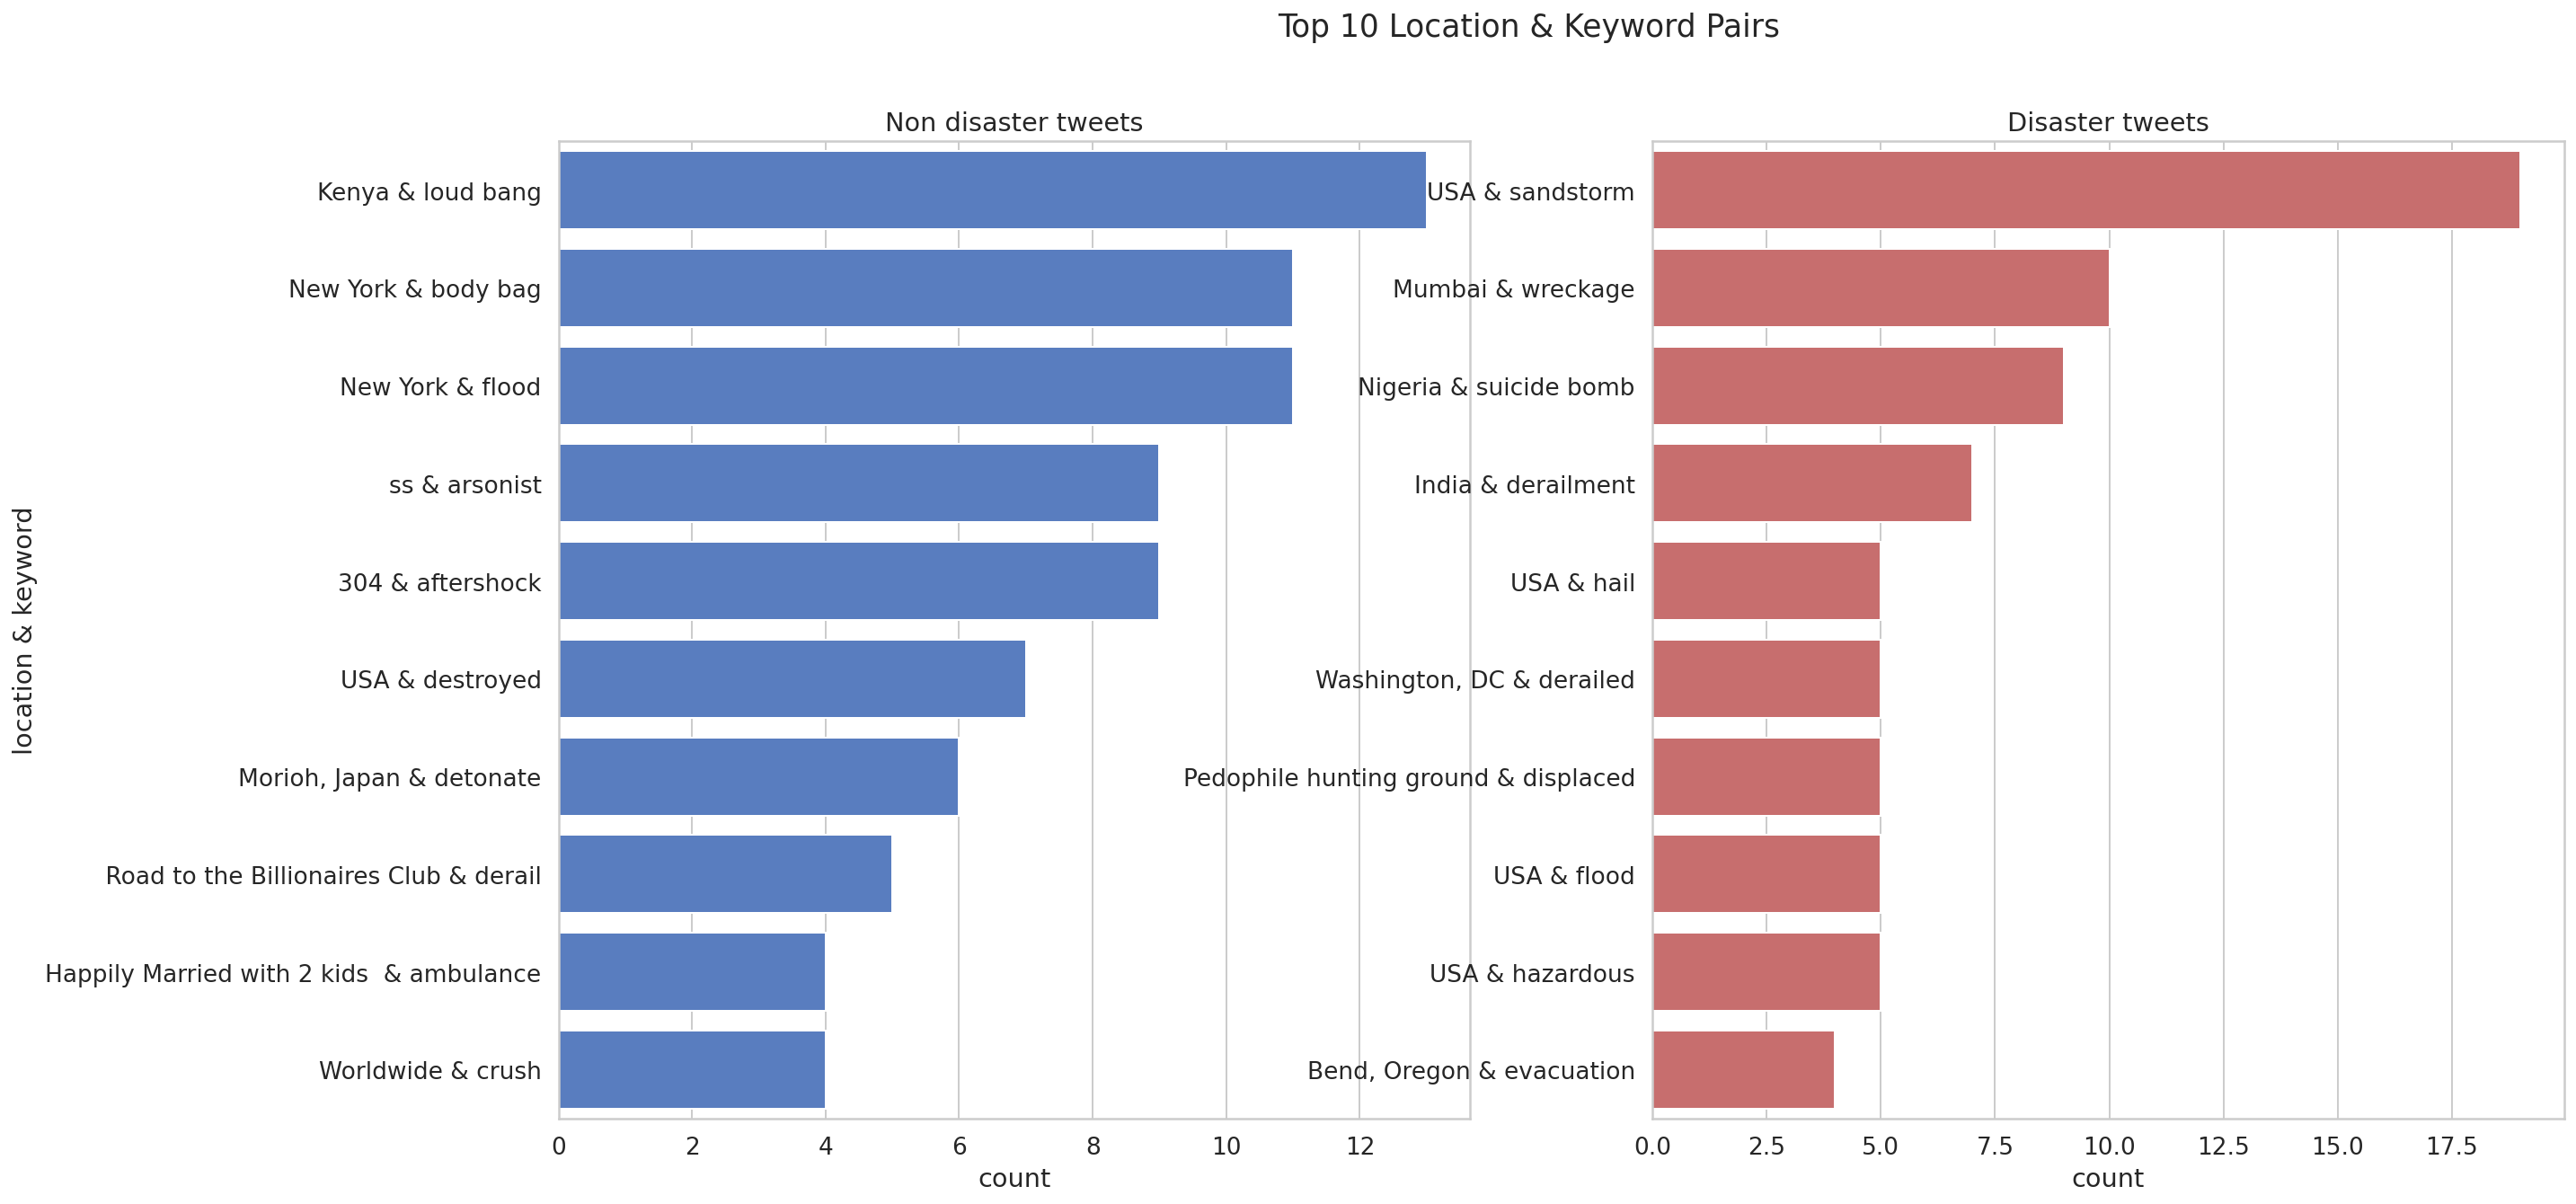

In [27]:
#top 10 locations & keywords pairs

train_df['location&keyword'] = train_df['location'] + ' & ' + train_df['keyword']

disaster_count = train_df[train_df['target']==1]['location&keyword'].value_counts()
none_disaster_count = train_df[train_df['target']==0]['location&keyword'].value_counts()

disaster_count = disaster_count[:10]
none_disaster_count = none_disaster_count[:10]

plt.figure(figsize=(10, 5))

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20,10))

sns.barplot(x=none_disaster_count.values, y=none_disaster_count.index, ax=ax1, color='b')
ax1.set(xlabel='count', ylabel='location & keyword', title='Non disaster tweets')

sns.barplot(x=disaster_count.values, y=disaster_count.index, ax=ax2, color='r')
ax2.set(xlabel='count', title='Disaster tweets')

plt.suptitle('Top 10 Location & Keyword Pairs')
plt.show()

Most common words, excluding stopwords and punctuation. No extremely valuable info here

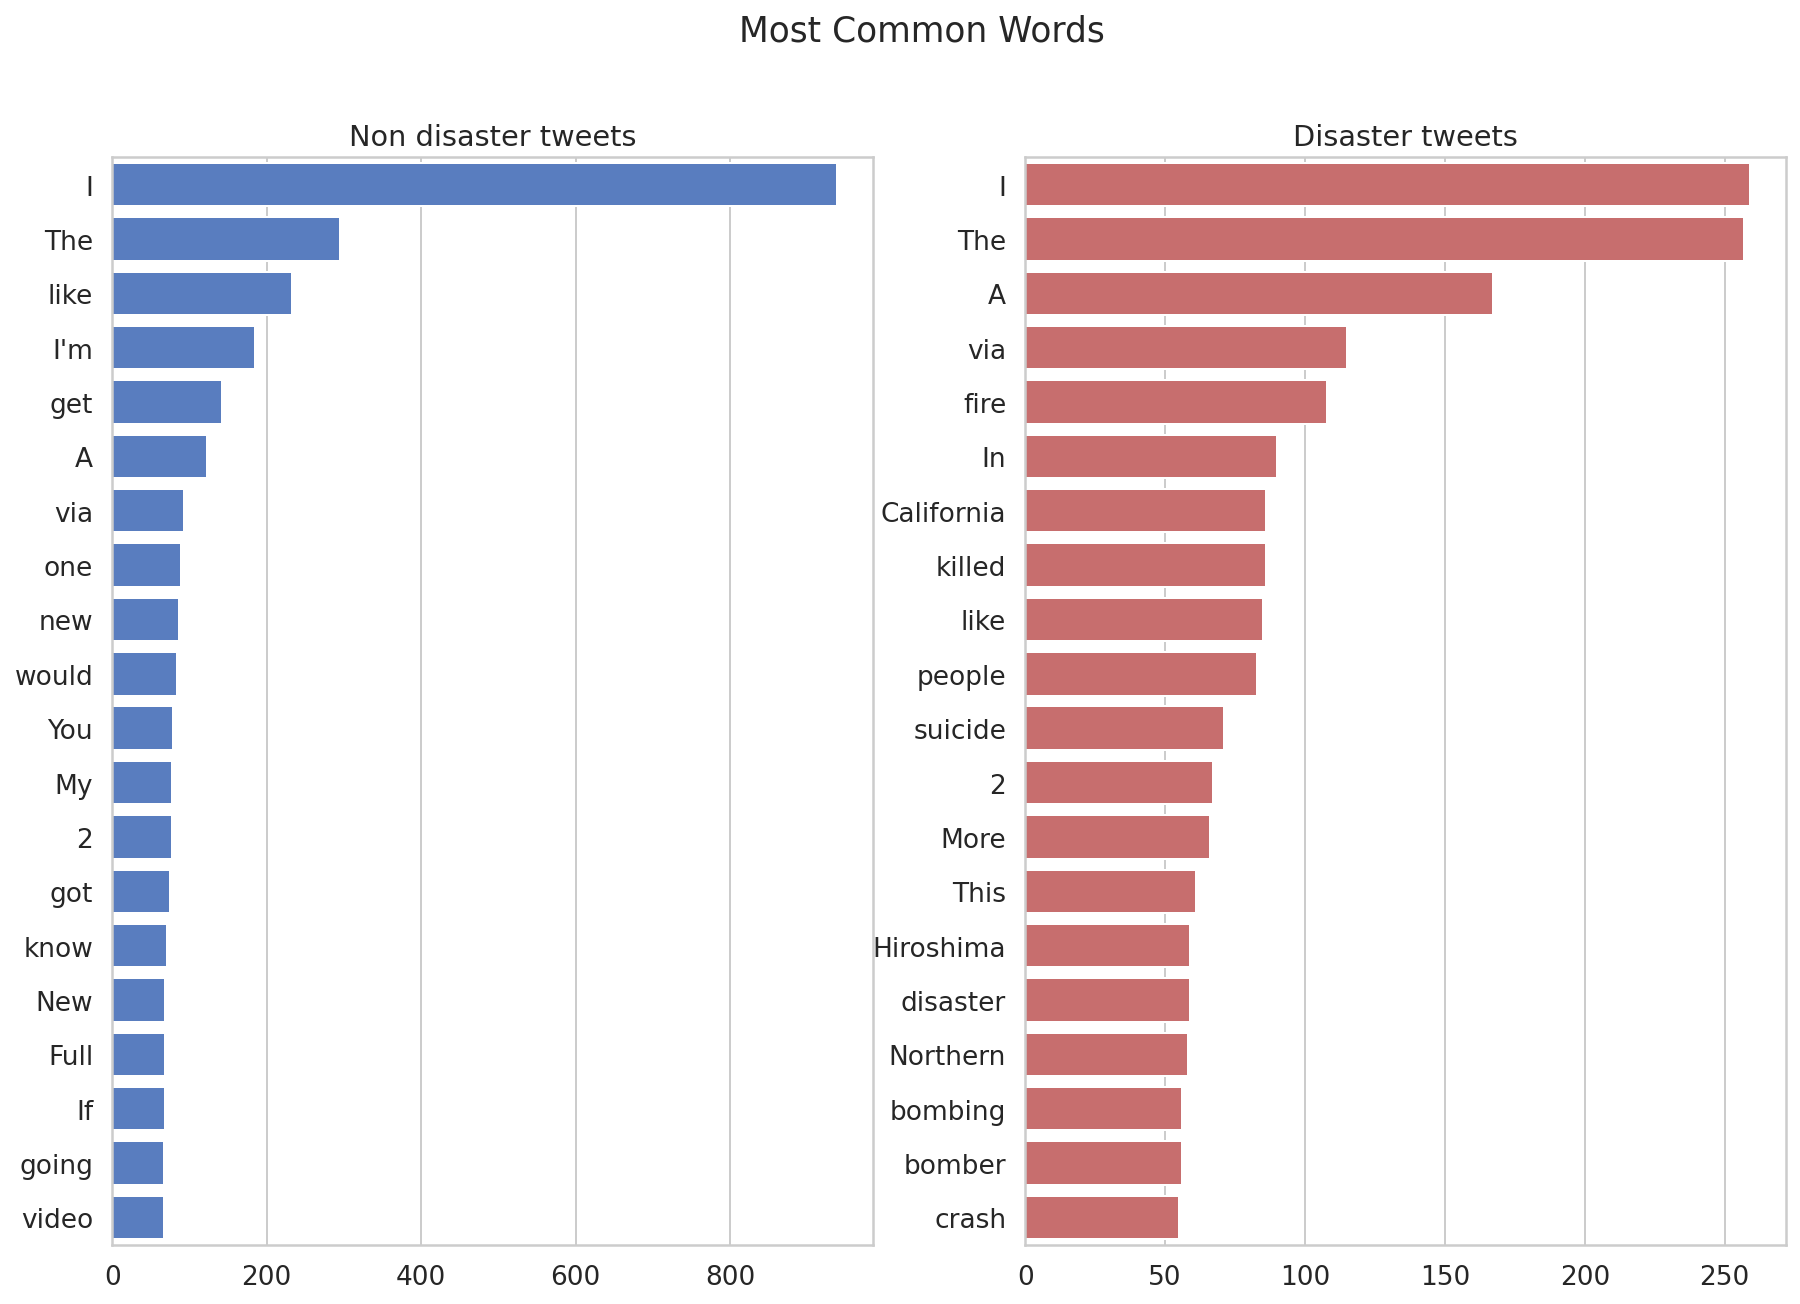

In [29]:
def create_corpus(target):
    corpus = []
    for x in train_df[train_df['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    
    return corpus

corpus_disaster = create_corpus(1)
corpus_nondisaster = create_corpus(0)


#most common words
stop_words = stopwords.words('english')
common_words_disaster = []
common_words_nondisaster = []

for word in corpus_disaster:
    if word not in stop_words and word[0] not in string.punctuation:
        common_words_disaster.append(word)
        
for word in corpus_nondisaster:
    if word not in stop_words and word[0] not in string.punctuation:
        common_words_nondisaster.append(word)
        
counter_disaster = Counter(common_words_disaster)
counter_nondisaster = Counter(common_words_nondisaster)

x_disaster, y_disaster = map(list, zip(*counter_disaster.most_common()[:20]))
x_nondisaster, y_nondisaster = map(list, zip(*counter_nondisaster.most_common()[:20]))

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(15,10))

sns.barplot(x=y_disaster, y=x_disaster, ax=ax2, color='r')
ax2.set_title('Disaster tweets')

sns.barplot(x=y_nondisaster, y=x_nondisaster, ax=ax1, color='b')
ax1.set_title('Non disaster tweets')

fig.suptitle('Most Common Words')
plt.show()

Tweet length distribution. Non-disaster tweets are somewhat longer, although this might be eliminated during text normalizing for modelling.

Text(0.5, 0.98, 'Number of words in tweets')

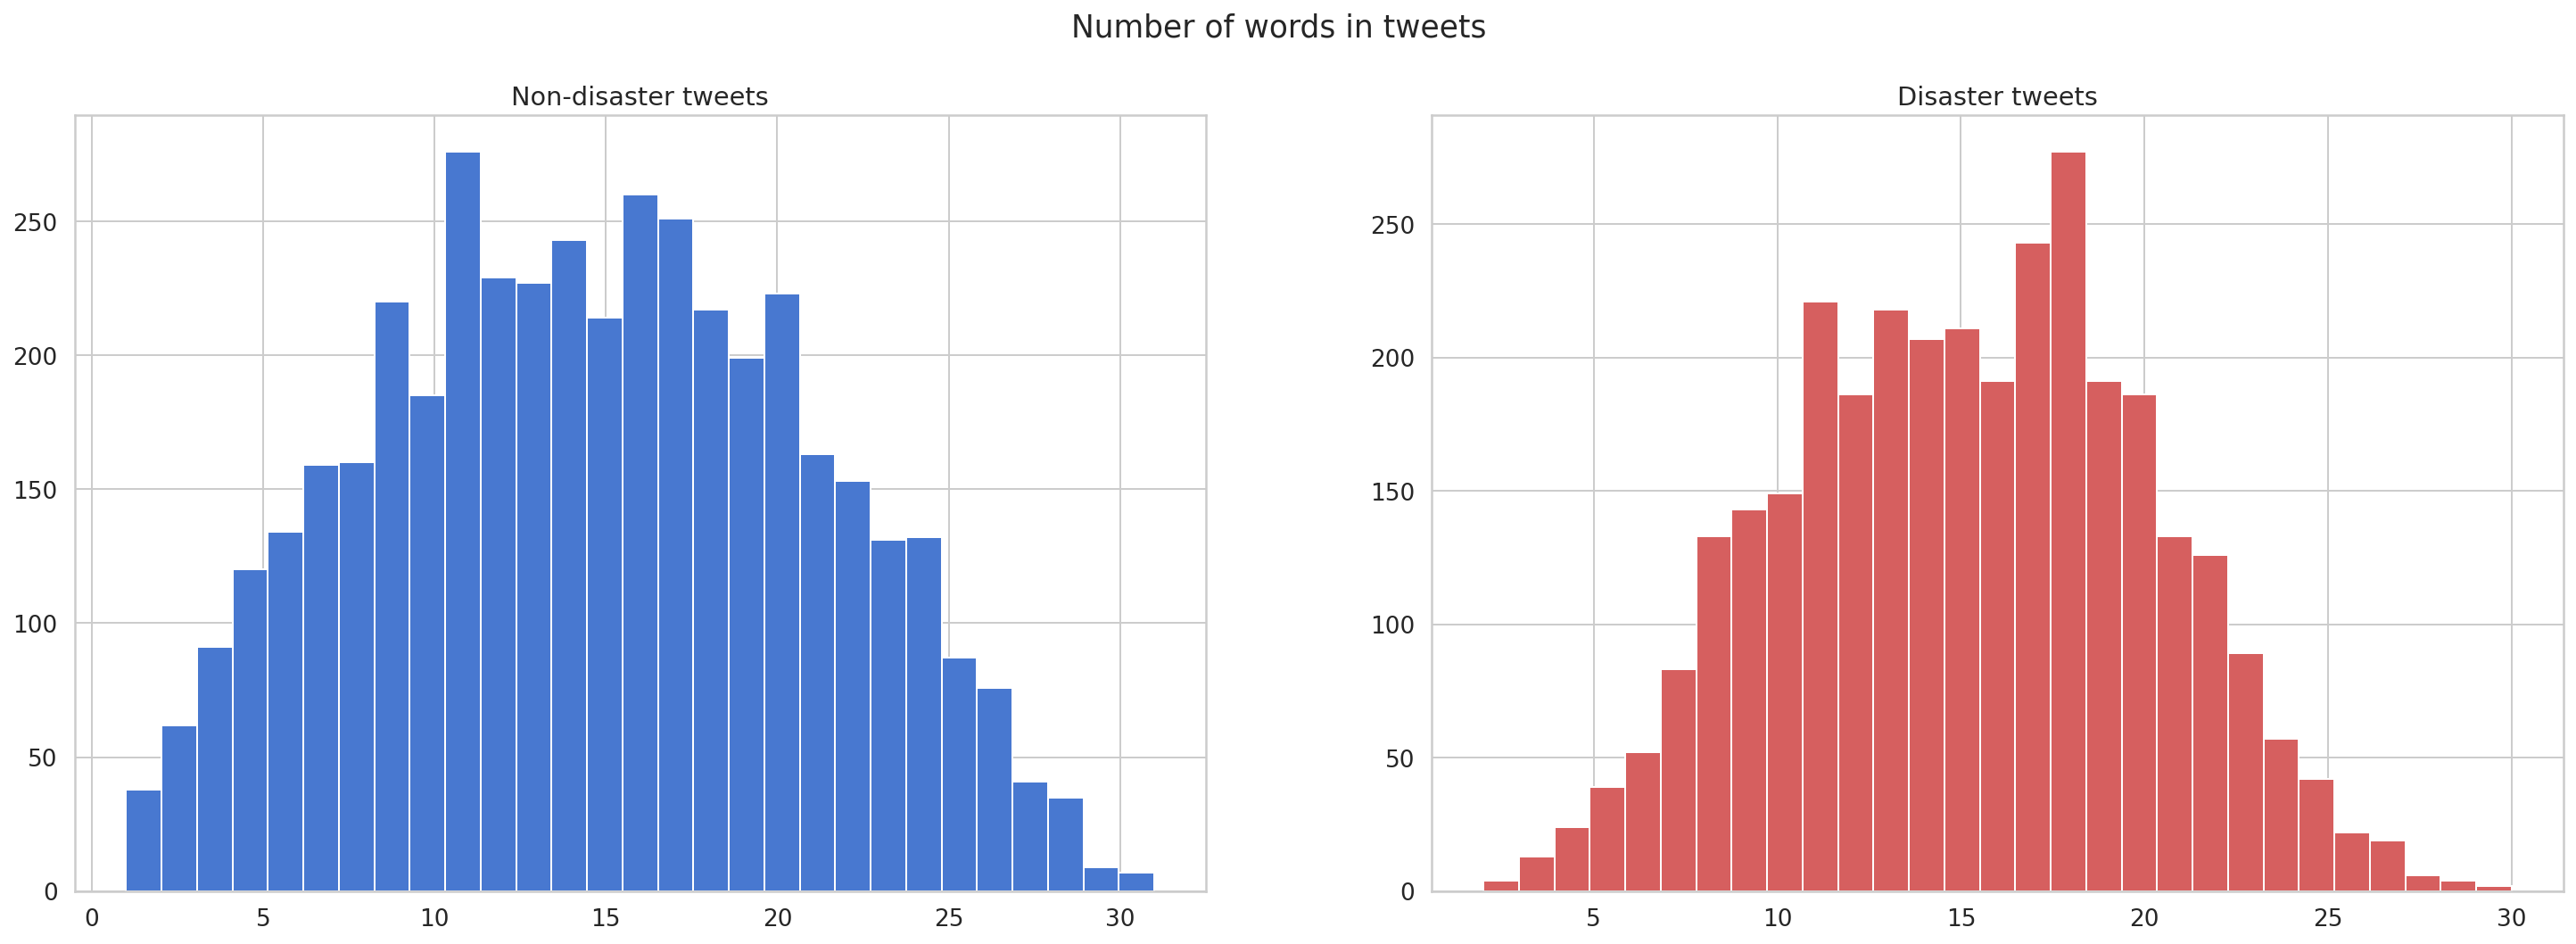

In [30]:
f, (ax1, ax2,) = plt.subplots(1,2,figsize=(25,8))

ax1.hist(train_df[train_df['target'] == 0]['text'].str.split().map(lambda x: len(x)), bins=29, color='b')
ax1.set_title('Non-disaster tweets')

ax2.hist(train_df[train_df['target'] == 1]['text'].str.split().map(lambda x: len(x)), bins=29, color='r')
ax2.set_title('Disaster tweets')

f.suptitle('Number of words in tweets')

There are some duplicates, we'll come back to this in a sec

In [31]:
train_df[train_df.text.duplicated()]

,id,keyword,location,text,target,location&keyword
48,68,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0,Live On Webcam & ablaze
115,165,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0,US & aftershock
119,172,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0,Switzerland & aftershock
164,238,airplane accident,NaN,Experts in France begin examining airplane deb...,1,NaN
624,898,bioterrorism,NaN,To fight bioterrorism sir.,0,NaN
...,...,...,...,...,...,...
7600,10855,nan,NaN,Evacuation order lifted for town of Roosevelt:...,1,NaN
7607,10867,nan,NaN,#stormchase Violent Record Breaking EF-5 El Re...,1,NaN
7609,10870,nan,NaN,@aria_ahrary @TheTawniest The out of control w...,1,NaN
7610,10871,nan,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,NaN


Let's proceed performing EDA after some text processing

Relabeling proposed by one of the kagglers, commented out a little by me

In [32]:
train_df['target_relabeled'] = train_df['target'].copy()

train_df.loc[train_df['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'To fight bioterrorism sir.', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target_relabeled'] = 1
train_df.loc[train_df['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target_relabeled'] = 1
#train_df.loc[train_df['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target_relabeled'] = 0
#train_df.loc[train_df['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'target_relabeled'] = 1
train_df.loc[train_df['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target_relabeled'] = 1
train_df.loc[train_df['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target_relabeled'] = 0
#train_df.loc[train_df['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target_relabeled'] = 0
#train_df.loc[train_df['text'] == "Caution: breathing may be hazardous to your health.", 'target_relabeled'] = 1
train_df.loc[train_df['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 'target_relabeled'] = 0


Replace all links and username mentions with @user and http. Most links are shortened so these don't contain any semantic info either way.

In [33]:
def normalize_user_http(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [34]:
train_df['user_link_norm'] = train_df['text'].apply(lambda s: normalize_user_http(s))
test_df['user_link_norm'] = test_df['text'].apply(lambda s: normalize_user_http(s))

In [35]:
train_df

,id,keyword,location,text,target,location&keyword,target_relabeled,user_link_norm
0,1,nan,NaN,Our Deeds are the Reason of this #earthquake M...,1,NaN,1,Our Deeds are the Reason of this #earthquake M...
1,4,nan,NaN,Forest fire near La Ronge Sask. Canada,1,NaN,1,Forest fire near La Ronge Sask. Canada
2,5,nan,NaN,All residents asked to 'shelter in place' are ...,1,NaN,1,All residents asked to 'shelter in place' are ...
3,6,nan,NaN,"13,000 people receive #wildfires evacuation or...",1,NaN,1,"13,000 people receive #wildfires evacuation or..."
4,7,nan,NaN,Just got sent this photo from Ruby #Alaska as ...,1,NaN,1,Just got sent this photo from Ruby #Alaska as ...
...,...,...,...,...,...,...,...,...
7608,10869,nan,NaN,Two giant cranes holding a bridge collapse int...,1,NaN,1,Two giant cranes holding a bridge collapse int...
7609,10870,nan,NaN,@aria_ahrary @TheTawniest The out of control w...,1,NaN,1,@user @user The out of control wild fires in C...
7610,10871,nan,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,NaN,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http
7611,10872,nan,NaN,Police investigating after an e-bike collided ...,1,NaN,1,Police investigating after an e-bike collided ...


Much more duplicates after usernames and links have been normalized. Lots of the same text in tweets

In [36]:
train_df[train_df.user_link_norm.duplicated()]

,id,keyword,location,text,target,location&keyword,target_relabeled,user_link_norm
48,68,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0,Live On Webcam & ablaze,0,Check these out: http http http http #nsfw
106,156,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0,US & aftershock,0,320 [IR] ICEMOON [AFTERSHOCK] | http | @user |...
114,164,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/M4...,0,Switzerland & aftershock,0,320 [IR] ICEMOON [AFTERSHOCK] | http | @user |...
115,165,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0,US & aftershock,0,320 [IR] ICEMOON [AFTERSHOCK] | http | @user |...
116,168,aftershock,NaN,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/e1...,0,NaN,0,320 [IR] ICEMOON [AFTERSHOCK] | http | @user |...
...,...,...,...,...,...,...,...,...
7608,10869,nan,NaN,Two giant cranes holding a bridge collapse int...,1,NaN,1,Two giant cranes holding a bridge collapse int...
7609,10870,nan,NaN,@aria_ahrary @TheTawniest The out of control w...,1,NaN,1,@user @user The out of control wild fires in C...
7610,10871,nan,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,NaN,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http
7611,10872,nan,NaN,Police investigating after an e-bike collided ...,1,NaN,1,Police investigating after an e-bike collided ...


There are no full duplicates

In [37]:
train_df[train_df.duplicated()]

,id,keyword,location,text,target,location&keyword,target_relabeled,user_link_norm


309 duplicates w/ the same normalized text, location and keyword

In [38]:
train_df[train_df[['location&keyword', 'user_link_norm']].duplicated()]

,id,keyword,location,text,target,location&keyword,target_relabeled,user_link_norm
48,68,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0,Live On Webcam & ablaze,0,Check these out: http http http http #nsfw
114,164,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/M4...,0,Switzerland & aftershock,0,320 [IR] ICEMOON [AFTERSHOCK] | http | @user |...
115,165,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0,US & aftershock,0,320 [IR] ICEMOON [AFTERSHOCK] | http | @user |...
118,171,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0,Switzerland & aftershock,0,320 [IR] ICEMOON [AFTERSHOCK] | http | @user |...
119,172,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0,Switzerland & aftershock,0,320 [IR] ICEMOON [AFTERSHOCK] | http | @user |...
...,...,...,...,...,...,...,...,...
7607,10867,nan,NaN,#stormchase Violent Record Breaking EF-5 El Re...,1,NaN,1,#stormchase Violent Record Breaking EF-5 El Re...
7608,10869,nan,NaN,Two giant cranes holding a bridge collapse int...,1,NaN,1,Two giant cranes holding a bridge collapse int...
7609,10870,nan,NaN,@aria_ahrary @TheTawniest The out of control w...,1,NaN,1,@user @user The out of control wild fires in C...
7610,10871,nan,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,NaN,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http


Let's drop duplicates that have same text and same targets (though different keywords/locations)

In [39]:
dropped = train_df.drop_duplicates(['user_link_norm','target_relabeled'], keep='last')

In [40]:
dropped

,id,keyword,location,text,target,location&keyword,target_relabeled,user_link_norm
0,1,nan,NaN,Our Deeds are the Reason of this #earthquake M...,1,NaN,1,Our Deeds are the Reason of this #earthquake M...
1,4,nan,NaN,Forest fire near La Ronge Sask. Canada,1,NaN,1,Forest fire near La Ronge Sask. Canada
2,5,nan,NaN,All residents asked to 'shelter in place' are ...,1,NaN,1,All residents asked to 'shelter in place' are ...
3,6,nan,NaN,"13,000 people receive #wildfires evacuation or...",1,NaN,1,"13,000 people receive #wildfires evacuation or..."
4,7,nan,NaN,Just got sent this photo from Ruby #Alaska as ...,1,NaN,1,Just got sent this photo from Ruby #Alaska as ...
...,...,...,...,...,...,...,...,...
7608,10869,nan,NaN,Two giant cranes holding a bridge collapse int...,1,NaN,1,Two giant cranes holding a bridge collapse int...
7609,10870,nan,NaN,@aria_ahrary @TheTawniest The out of control w...,1,NaN,1,@user @user The out of control wild fires in C...
7610,10871,nan,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,NaN,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http
7611,10872,nan,NaN,Police investigating after an e-bike collided ...,1,NaN,1,Police investigating after an e-bike collided ...


Samples that have different labels despite the same normalized text (may have different location&keyword though but we'll ignore that)

In [41]:
norm_text_duplicates = dropped[dropped.user_link_norm.duplicated(keep=False)]
target_counts = norm_text_duplicates.groupby('user_link_norm')['target_relabeled'].apply(lambda x: len(list(np.unique(x)))).to_frame().reset_index()
target_dupl = target_counts[target_counts.target_relabeled>1]
target_dupl

,user_link_norm,target_relabeled
0,#360WiseNews : China's Stock Market Crash: Are...,2
1,#foodscare #offers2go #NestleIndia slips into ...,2
2,#hot C-130 specially modified to land in a st...,2
3,#hot Funtenna: hijacking computers to send da...,2
4,#hot Reddit's new content policy goes into ef...,2
5,#world FedEx no longer to transport bioterror ...,2
6,2pcs 18W CREE Led Work Light Offroad Lamp Car...,2
7,?? New Ladies Shoulder Tote #Handbag Faux Leat...,2
8,@user #FETTILOOTCH IS #SLANGLUCCI OPPRESSIONS ...,2
9,@user ChinaÛªs stock market crash this summer...,2


Let's decide which label it is intuitively and drop the duplicates after.

Naturally, it is extremely hard to decide between disaster/non disaster from just the raw tweet text and not diving into the context. The challenge description is also a little vague as it is not completely clear how to classift some of the cases such as distant disasters (WW2), potential disasters (petitions), movies/books abaut disasters, how to deal with exaggerations of probably real disasters (yellow press), etc.

Diving deep into the source material and its context is essential for the tasks like that since good data is the largest possible source of model performance improvement, and improving the quality of the data could get us the largest boost - but it would also require a lot of time and human resources that I don't have at the moment, so I'll go with present human-labeled samples with just a little processing of my own.

In [42]:
import warnings
warnings.filterwarnings("ignore")

In [43]:
for i in range(len(target_dupl)):
  print(target_dupl.loc[i].user_link_norm)
  new_label = input('Enter label (0/1): ')
  dropped.loc[dropped.user_link_norm==target_dupl.loc[i].user_link_norm, 'target_relabeled'] = new_label

#360WiseNews : China's Stock Market Crash: Are There Gems In The Rubble? http
Enter label (0/1): 1
#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption
Enter label (0/1): 1
#hot  C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http #prebreak #best
Enter label (0/1): 1
#hot  Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http #prebreak #best
Enter label (0/1): 1
#hot  Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http #prebreak #best
Enter label (0/1): 0
#world FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps  http
Enter label (0/1): 1
2pcs 18W CREE Led Work Light  Offroad Lamp Car Truck Boat Mining 4WD FLOOD BEAM - Full reaÛ_ http http
Enter label (0/1): 0
?? New Ladies Shoulder Tote #Handbag Faux Leather Hobo Purse Cross Body Bag #Womens http http
Enter label (0/1): 0
@user #FETTILOOTCH 

In [44]:
norm_text_duplicates = dropped[dropped.user_link_norm.duplicated(keep=False)]
target_counts = norm_text_duplicates.groupby('user_link_norm')['target_relabeled'].apply(lambda x: len(list(np.unique(x)))).to_frame().reset_index()
target_dupl = target_counts[target_counts.target_relabeled>1]
target_dupl

,user_link_norm,target_relabeled


Drop all the false samples we aquired due to the relabeling

In [45]:
dropped_filtered = dropped[dropped['target'] == dropped['target_relabeled']]

In [46]:
dropped_filtered

,id,keyword,location,text,target,location&keyword,target_relabeled,user_link_norm
0,1,nan,NaN,Our Deeds are the Reason of this #earthquake M...,1,NaN,1,Our Deeds are the Reason of this #earthquake M...
1,4,nan,NaN,Forest fire near La Ronge Sask. Canada,1,NaN,1,Forest fire near La Ronge Sask. Canada
2,5,nan,NaN,All residents asked to 'shelter in place' are ...,1,NaN,1,All residents asked to 'shelter in place' are ...
3,6,nan,NaN,"13,000 people receive #wildfires evacuation or...",1,NaN,1,"13,000 people receive #wildfires evacuation or..."
4,7,nan,NaN,Just got sent this photo from Ruby #Alaska as ...,1,NaN,1,Just got sent this photo from Ruby #Alaska as ...
...,...,...,...,...,...,...,...,...
7608,10869,nan,NaN,Two giant cranes holding a bridge collapse int...,1,NaN,1,Two giant cranes holding a bridge collapse int...
7609,10870,nan,NaN,@aria_ahrary @TheTawniest The out of control w...,1,NaN,1,@user @user The out of control wild fires in C...
7610,10871,nan,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,NaN,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http
7611,10872,nan,NaN,Police investigating after an e-bike collided ...,1,NaN,1,Police investigating after an e-bike collided ...


Export train df

In [47]:
dropped_filtered[['id', 'keyword','location', 'text', 'user_link_norm', 'target_relabeled']].to_csv('new_train.csv', index=False)

Surely we'll keep all the duplicates in test set, just apply some defined feature transformations

In [48]:
test_df['keyword'] = test_df['keyword'].apply(lambda x: str(x).replace('%20', ' '))
test_df.loc[test_df['location']=='United States', 'location'] = 'USA' #normalize USA
test_df.loc[test_df['location']=='NYC', 'location'] = 'New York' #normalize NYC
test_df.loc[test_df['location']=='UK', 'location'] = 'United Kingdom' #normalize UK
test_df.loc[test_df['location']=='Everywhere', 'location'] = 'Worldwide' #normalize Everywhere

Export test df

In [49]:
test_df.to_csv('new_test.csv', index=False)